# Domain Adaptation

- Implementation of the paper [Domain-Adversarial Training of Neural Networks](https://arxiv.org/pdf/1505.07818.pdf)
- The datasets used in this demo are available [here](https://drive.google.com/drive/folders/1-GSAgz0IBT8LWbn2p1gApsLoeqMpAsOo?usp=sharing)

In [1]:
import tensorflow as tf
import sys
import numpy as np
import pickle
import matplotlib.pylab as plt
from skimage.color import gray2rgb
from skimage.transform import resize

In [ ]:
# Data generator for domain adversarial neural network
class DataGeneratorDANN(tf.keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, source_images, source_labels,  target_images, source_train = True, batch_size = 32, shuffle = True):

        self.source_images = source_images 
        self.source_labels = source_labels
        self.target_images = target_images
        self.batch_size = batch_size
        self.nsamples = source_images.shape[0]
        self.shuffle = shuffle
        self.source_train = source_train
        self.on_epoch_end()
        
    def set_source_train(self,flag):
        self.source_train = flag
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return np.ceil(self.nsamples/self.batch_size).astype(int)

    def __getitem__(self, index):
        'Generate one batch of data'

        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        return self.__data_generation(batch_indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.nsamples)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        'Generates data containing batch_size samples'
    
        Xsource = self.source_images[batch_indexes]
        Ysource = self.source_labels[batch_indexes]
        Xtarget = self.target_images[batch_indexes]
        if self.source_train:
            return Xsource, Ysource
        else:
            return Xsource, Ysource, Xtarget
            
# Model with no domain adaptation
def model_NDA(ishape = (32,32,3)):
    input_layer = tf.keras.layers.Input(ishape)
    x1 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu')(input_layer)
    x2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu')(x1)
    x3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x2)
    x4 = tf.keras.layers.BatchNormalization()(x3)
    
    x5 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu')(x4)
    x6 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu')(x5)
    x7 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x6)
    x8 = tf.keras.layers.BatchNormalization()(x7)
    # Feature vector
    x9 = tf.keras.layers.Flatten()(x8)
    
    # Label classifier
    out = tf.keras.layers.Dense(10, activation = "softmax")(x9)
    
    model = tf.keras.models.Model(inputs = [input_layer], outputs = [out])
    return model    

#Gradient Reversal Layer
@tf.custom_gradient
def gradient_reverse(x, lamda=1.0):
    y = tf.identity(x)
    
    def grad(dy):
        return lamda * -dy, None
    
    return y, grad


class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x, lamda=1.0):
        return gradient_reverse(x, lamda)

# Domain adversarial neural network implementation
class DANN(tf.keras.models.Model):
    def __init__(self):
        super().__init__()

        #Feature Extractor
        self.feature_extractor_layer0 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu')
        self.feature_extractor_layer1 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu')
        self.feature_extractor_layer2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.feature_extractor_layer3 = tf.keras.layers.BatchNormalization()
        
        
        self.feature_extractor_layer4 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu')
        self.feature_extractor_layer5 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu')
        self.feature_extractor_layer6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.feature_extractor_layer7 = tf.keras.layers.BatchNormalization()
        
        #Label Predictor
        self.label_predictor_layer0 = tf.keras.layers.Dense(10, activation= 'softmax')
        
        #Domain Predictor
        self.domain_predictor_layer0 = GradientReversalLayer()
        self.domain_predictor_layer1 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x, train=False, source_train=True, lamda=1.0):
        
        #Feature Extractor
        x = self.feature_extractor_layer0(x)
        x = self.feature_extractor_layer1(x)
        x = self.feature_extractor_layer2(x)
        x = self.feature_extractor_layer3(x , training=train)
        
        x = self.feature_extractor_layer4(x)
        x = self.feature_extractor_layer5(x)
        x = self.feature_extractor_layer6(x)
        x = self.feature_extractor_layer7(x, training=train)
        
        features = tf.keras.layers.Flatten()(x)
        
        
        #Label Predictor
        if source_train is True:
            feature_slice = features
        else:
            feature_slice = tf.slice(features, [0, 0], [features.shape[0] // 2, -1])
        
        #Label Predictor
        l_logits = self.label_predictor_layer0(feature_slice)
        
        #Domain Predictor
        if source_train is True:
            return l_logits
        else:
            dp_x = self.domain_predictor_layer0(features, lamda)    #GradientReversalLayer
            d_logits = self.domain_predictor_layer1(dp_x)
            
            return l_logits, d_logits


In [2]:
# Loading source domain data
with open('..//Data/mnist_data.pkl', 'rb') as f:
    mnist = pickle.load(f)

x_source_train = mnist["train"]
y_source_train = mnist["train_labels"].astype(np.float32)
x_source_val = mnist["val"]
y_source_val  = mnist["val_labels"].astype(np.float32)
x_source_test = mnist["test"]
y_source_test = mnist["test_labels"].astype(np.float32)

# Loading target domain data
with open('..//Data/mnistm_data.pkl', 'rb') as f:
    mnistm = pickle.load(f)

x_target_train = mnistm["train"]
y_target_train = mnistm["train_labels"].astype(np.float32)
x_target_val = mnistm["val"]
y_target_val  = mnistm["val_labels"].astype(np.float32)
x_target_test = mnistm["test"]
y_target_test = mnistm["test_labels"].astype(np.float32)

print(y_target_test.shape)
print(x_target_test.shape)

(10000,)
(10000, 28, 28, 3)


In [3]:
print(x_source_train.shape)
print(x_target_train.shape)

(48000, 28, 28)
(48000, 28, 28, 3)


In [4]:
def process_mnist(x):
    x = np.moveaxis(x, 0, -1)
    if x.ndim == 3:
        x = resize(x, (32, 32), anti_aliasing=True, mode='constant')
    else:
        x = resize(x, (32, 32,3), anti_aliasing=True, mode='constant')
    x = np.moveaxis(x, -1, 0)
    if x.ndim == 3:
        return gray2rgb(x).astype("float32")
    else:
        return x.astype("float32")


x_source_train = process_mnist(x_source_train)
x_source_val = process_mnist(x_source_val)
x_source_test = process_mnist(x_source_test)

x_target_train = process_mnist(x_target_train)
x_target_val = process_mnist(x_target_val)
x_target_test = process_mnist(x_target_test)

In [5]:
print(x_source_train.shape)
print(x_target_train.shape)

(48000, 32, 32, 3)
(48000, 32, 32, 3)


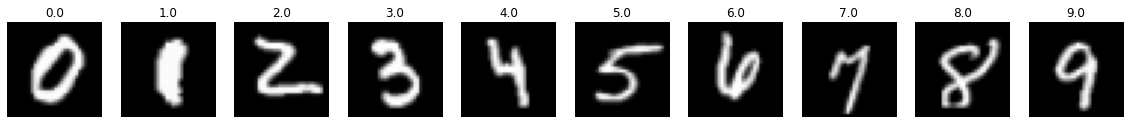

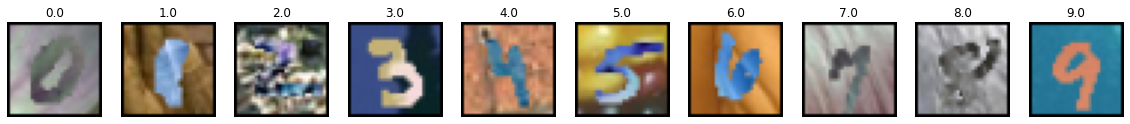

In [6]:
plt.figure(figsize=(20, 15))
for i, digit in enumerate(np.unique(y_source_train), start=1):
    index = np.where(y_source_train == digit)[0][0]
    ax = plt.subplot(1, 10, i)
    ax.imshow(x_source_train[index])
    ax.axis("off")
    ax.set_title(digit)
    
plt.figure(figsize=(20, 15))
for i, digit in enumerate(np.unique(y_target_train), start=1):
    index = np.where(y_source_train == digit)[0][0]
    ax = plt.subplot(1, 10, i)
    ax.imshow(x_target_train[index])
    ax.axis("off")
    ax.set_title(digit)

In [ ]:
model = model_NDA()
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
print(model.summary())

In [ ]:
model.fit(x_source_train,y_source_train, epochs = 20, batch_size = 128, \
          validation_data = (x_source_val, y_source_val))

In [ ]:
print("Source domain loss and accuarcy")
model.evaluate(x_source_test, y_source_test)
print("Target domain loss and accuarcy")
model.evaluate(x_target_test, y_target_test)

In [9]:
BATCH_SIZE = 32
EPOCH = 100

model = DANN()

model_optimizer = tf.optimizers.Adam(1e-4)

domain_labels = np.zeros(2*BATCH_SIZE)
domain_labels[:BATCH_SIZE] = 1
domain_labels = domain_labels.astype('float32')


epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
source_acc = []  # Source Domain Accuracy while Source-only Training
da_acc = []      # Source Domain Accuracy while DA-training
val_acc = []    # Testing Dataset (Target Domain) Accuracy 
val2_acc = []   # Target Domain (used for Training) Accuracy

train_gen = DataGeneratorDANN(x_source_train, y_source_train,  x_target_train, batch_size = BATCH_SIZE)
test_gen  = DataGeneratorDANN(x_source_test, y_source_test,  x_target_test, batch_size = BATCH_SIZE)
test_gen2  = DataGeneratorDANN(x_source_test, y_source_test,  x_target_test, batch_size = BATCH_SIZE, source_train = False)

In [ ]:
def loss_func(input_logits, target_labels):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(target_labels, input_logits ))


def get_loss(l_logits, labels, d_logits=None, domain=None):
    if d_logits is None:
        return loss_func(l_logits, labels)
    else:
        return loss_func(l_logits, labels)  + loss_func(d_logits, domain)
    
@tf.function
def train_step_source(s_images, s_labels, lamda=1.0):
    images = s_images
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=True, lamda=lamda) # forward nn pass
        
        model_loss = get_loss(output, labels)
        epoch_accuracy(labels, output)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables) # backpropagation of the NN
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


@tf.function
def train_step_da(s_images, s_labels, t_images=None, t_labels=None, lamda=1.0):
    images = tf.concat([s_images, t_images], 0)
    labels = s_labels
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=False, lamda=lamda)
        model_loss = get_loss(output[0], labels, output[1], domain_labels)
        epoch_accuracy( labels, output[0])
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


@tf.function
def test_step(t_images, t_labels):
    images = t_images
    labels = t_labels
    
    output = model(images, train=False, source_train=True)
    epoch_accuracy(labels, output)

def train(train_mode, epochs=EPOCH):
    
    if train_mode == 'source':
        train_gen.set_source_train(True)
        train_func = train_step_source
        acc_list = source_acc
    elif train_mode == 'domain-adaptation':
        train_gen.set_source_train(False)
        train_func = train_step_da
        acc_list = da_acc
    else:
        raise ValueError("Unknown training Mode")
    
    for epoch in range(epochs):
        p = float(epoch) / epochs
        lamda = 2 / (1 + np.exp(-100 * p, dtype=np.float32)) - 1
        lamda = lamda.astype('float32')

        for batch in train_gen:
            train_func(*batch, lamda=lamda)
        
        print("Training: Epoch {} :\t Source Accuracy : {:.3%}".format(epoch, epoch_accuracy.result()), end='  |  ')
        acc_list.append(epoch_accuracy.result())
        test()
        epoch_accuracy.reset_states()


def test():
    epoch_accuracy.reset_states()
    
    #Testing Dataset (Target Domain)
    for batch in test_gen:
        test_step(*batch)
        
    print("Testing Accuracy : {:.3%}".format(epoch_accuracy.result()), end='  |  ')
    test_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()
    
    #Target Domain (used for Training)
    for batch in test_gen2:
        test_step(batch[2],batch[1])
    
    print("Target Domain Accuracy : {:.3%}".format(epoch_accuracy.result()))
    test2_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()

train('source',  5)
train('domain-adaptation',  EPOCH)


#Plot Results
x_axis = [i for i in range(0, EPOCH)]

plt.plot(x_axis, da_acc, label="source accuracy")
plt.plot(x_axis, test_acc, label="testing accuracy")
plt.plot(x_axis, test2_acc, label="target accuracy")
plt.legend()

Training: Epoch 0 :	 Source Accuracy : 29.229%  |  Testing Accuracy : 44.420%  |  Target Domain Accuracy : 16.460%
Training: Epoch 1 :	 Source Accuracy : 53.829%  |  Testing Accuracy : 63.260%  |  Target Domain Accuracy : 21.150%
Training: Epoch 2 :	 Source Accuracy : 67.200%  |  Testing Accuracy : 73.180%  |  Target Domain Accuracy : 24.120%
Training: Epoch 3 :	 Source Accuracy : 74.402%  |  Testing Accuracy : 78.720%  |  Target Domain Accuracy : 26.310%
Training: Epoch 4 :	 Source Accuracy : 78.754%  |  Testing Accuracy : 82.190%  |  Target Domain Accuracy : 27.910%
Training: Epoch 0 :	 Source Accuracy : 9.890%  |  Testing Accuracy : 9.800%  |  Target Domain Accuracy : 9.800%
Training: Epoch 1 :	 Source Accuracy : 9.856%  |  Testing Accuracy : 9.800%  |  Target Domain Accuracy : 9.800%
Training: Epoch 2 :	 Source Accuracy : 9.856%  |  Testing Accuracy : 9.800%  |  Target Domain Accuracy : 9.800%
Training: Epoch 3 :	 Source Accuracy : 9.856%  |  Testing Accuracy : 9.800%  |  Target Do

In [ ]:
output = model(train_gen.__getitem__(10)[0], train=False, source_train=True)

In [ ]:
model.build((32,32,32,3))
print(model.feature_extractor_layer5.weights)